In [86]:
#load path
import os
import sys
import astropy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.wcs import WCS
from astropy.visualization import (ImageNormalize, ZScaleInterval, LogStretch)
import glob
from mypython.filters import filter as flt

Filter wave range 5440.0 7080.0
Data   wave range 3200.0 9200.0
Actual integration 5440.0 7080.0
Filter wave range 5440.0 7080.0
Data   wave range 3200.0 9200.0
Actual integration 5440.0 7080.0
Filter wave range 3950.0 5770.0
Data   wave range 3200.0 9200.0
Actual integration 3950.0 5770.0
Filter wave range 3950.0 5770.0
Data   wave range 3200.0 9200.0
Actual integration 3950.0 5770.0
Filter wave range 6770.0 8580.0
Data   wave range 3200.0 9200.0
Actual integration 6770.0 8580.0
Filter wave range 6770.0 8580.0
Data   wave range 3200.0 9200.0
Actual integration 6770.0 8580.0


/Users/michele/codes/python/mypython/filters/filter.py:86: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  numer = integrate.quad(lambda x: listint(x)*filtint(x), minint, maxint, limit=100, epsabs=1e-4, epsrel=1e-4)
/Users/michele/codes/python/mypython/filters/filter.py:87: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  pr

Filter wave range 6679.799805 6775.3302
Data   wave range 3200.0 9200.0
Actual integration 6679.799805 6775.3302
Filter wave range 6679.799805 6775.3302
Data   wave range 3200.0 9200.0
Actual integration 6679.799805 6775.3302
Filter wave range 4960.19989 5064.349976
Data   wave range 3200.0 9200.0
Actual integration 4960.19989 5064.349976
Filter wave range 4960.19989 5064.349976
Data   wave range 3200.0 9200.0
Actual integration 4960.19989 5064.349976
Filter wave range 6533.079834 6615.209961
Data   wave range 3200.0 9200.0
Actual integration 6533.079834 6615.209961
Filter wave range 6533.079834 6615.209961
Data   wave range 3200.0 9200.0
Actual integration 6533.079834 6615.209961
Filter wave range 4732.0 5048.0
Data   wave range 3200.0 9200.0
Actual integration 4732.0 5048.0
Filter wave range 4732.0 5048.0
Data   wave range 3200.0 9200.0
Actual integration 4732.0 5048.0


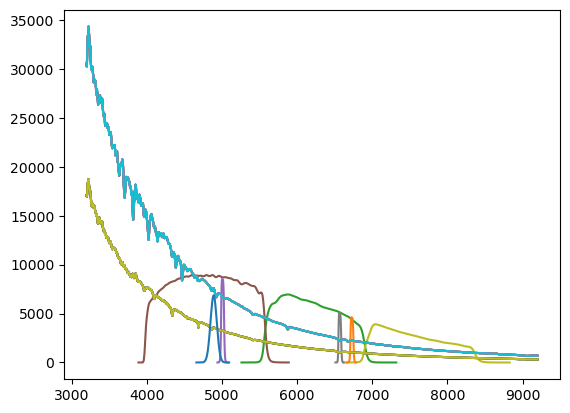

In [87]:
#load the spectra for STD
stdbd28 = Table.read("fbd28d4211.dat",format="ascii")
stdbd25 = Table.read("fbd25d4655.dat",format="ascii")

listfilter={'R':166,'G':165,'I':167,'SII':163,'OIII':164,'Ha':162,'Hb':168}

coefflux28={}
coefflux25={}


for filt in listfilter.keys():
    clsfilt = flt.Filter(listfilter[filt])
    clsfilt.loadtrans()

    c28=clsfilt.convolve(stdbd28['col2'],stdbd28['col1'])
    c25=clsfilt.convolve(stdbd25['col2'],stdbd25['col1'])

    coefflux28[filt]=c28
    coefflux25[filt]=c25

    plt.plot(stdbd28['col1'],stdbd28['col2'],label='BD+28')
    plt.plot(stdbd25['col1'],stdbd25['col2'],label='BD+25')
    plt.plot(clsfilt.filter['wave'],clsfilt.filter['tran']*1e4)


In [88]:
print(coefflux28)
print(coefflux25)

{'R': 1467.4596228837956, 'G': 4106.737056951673, 'I': 700.9762036734105, 'SII': 1031.684801331771, 'OIII': 3229.7191370370047, 'Ha': 1033.8452933691092, 'Hb': 3504.21219383391}
{'R': 3145.592568706369, 'G': 8481.484334774455, 'I': 1506.5872046310358, 'SII': 2226.362917731856, 'OIII': 6690.680596282725, 'Ha': 2275.5512423716214, 'Hb': 7321.223177211238}


In [113]:
#now do ap phot
from photutils.aperture import CircularAperture, aperture_photometry, CircularAnnulus
from photutils.centroids import centroid_com

reduxpath='./data/Redux/'
bd28names = glob.glob(reduxpath+'/*_BD28*.fits')
bd25names = glob.glob(reduxpath+'/*_BD25*.fits')


zpall = {}
skyall = {}
for filt in listfilter.keys():
    zpall[filt] = []
    skyall[filt] = []

In [114]:
#start with BD28
def runzp(imgname,coefflux):
    hdu=fits.open(imgname)
    img=hdu[0].data
    hdr=hdu[0].header
    wcs=WCS(hdr)
    #get filter
    filter=hdr['FILTER']
    #convert to pixel
    x,y=wcs.all_world2pix(ra,dec,1)
    #compute centroid for better accuracy
    xnew,ynew=centroid_com(img[int(y)-10:int(y)+10,int(x)-10:int(x)+10])
    xcnt=int(x)+xnew-10
    ycnt=int(y)+ynew-10
    positions = [(xcnt, ycnt)]

    #subtract the background in an annulus
    skyapert = CircularAnnulus(positions, 45, 90)
    apertures = CircularAperture(positions, r=40.)
    phot_table = aperture_photometry(img, apertures)
    sky_table = aperture_photometry(img, skyapert)
    skyinapertre = sky_table['aperture_sum'] / skyapert.area * apertures.area
    #store sky/arcsec^2
    skyall[filter].append(sky_table['aperture_sum']/(skyapert.area*(hdr['CD2_2']*3600)**2))
    flux=phot_table['aperture_sum'][0]-skyinapertre[0]
    #calculate zeropoint
    zp=(np.log10(coefflux[filter]/flux)-16)
    print('ZP for ', imgname, ' with filter ', filter, ' is ', zp)
    zpall[filter].append(zp)
    #display image
    plt.imshow(img,cmap='gray',norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LogStretch()))
    plt.xlim(int(xcnt)-200,int(xcnt)+200)
    plt.ylim(int(ycnt)-200,int(ycnt)+200)
    #overplot aperture
    apertures.plot(color='red', lw=1.5, alpha=0.5)
    skyapert.plot(color='blue', lw=1.5, alpha=0.5)
    plt.show()


Set MJD-AVG to 60946.816803 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/19-35-11_Ha_BD28_120.00s_0002_reduced.fits  with filter  Ha  is  -14.736885596109161


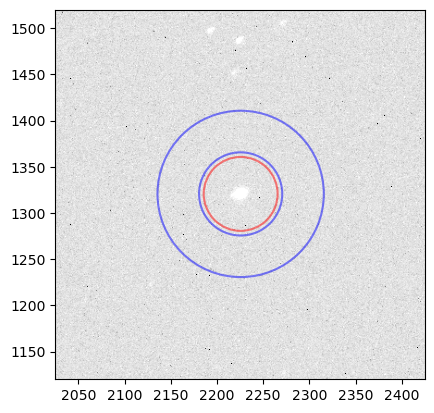

Set MJD-AVG to 60946.811416 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/19-28-13_R_BD28_25.00s_0001_reduced.fits  with filter  R  is  -16.263267718840464


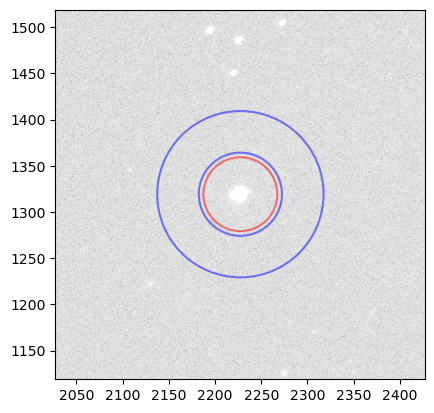

Set MJD-AVG to 60946.825223 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/19-47-19_OIII_BD28_120.00s_0002_reduced.fits  with filter  OIII  is  -14.77175141568965


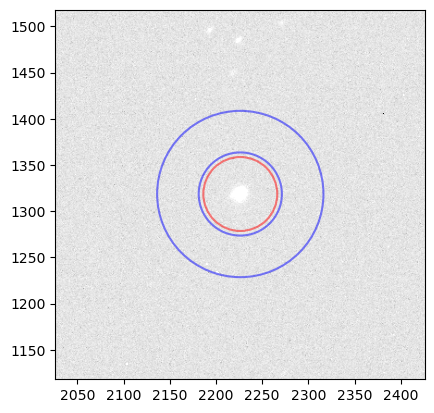

Set MJD-AVG to 60946.810500 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/19-26-54_G_BD28_25.00s_0001_reduced.fits  with filter  G  is  -16.261814819688773


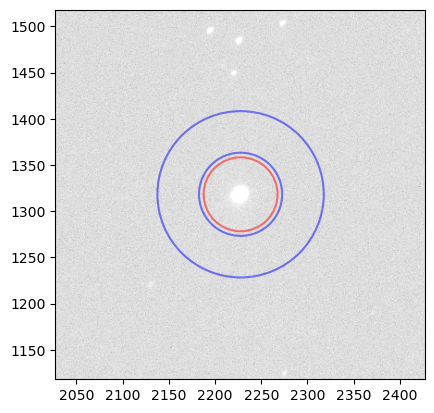

Set MJD-AVG to 60946.812112 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/19-29-06_I_BD28_40.00s_0000_reduced.fits  with filter  I  is  -16.057043784375697


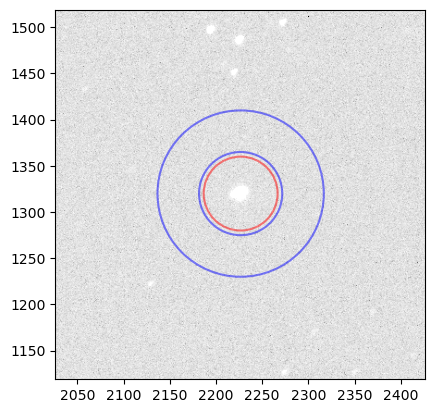

Set MJD-AVG to 60946.826636 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/19-49-20_SII_BD28_120.00s_0000_reduced.fits  with filter  SII  is  -14.759037771858194


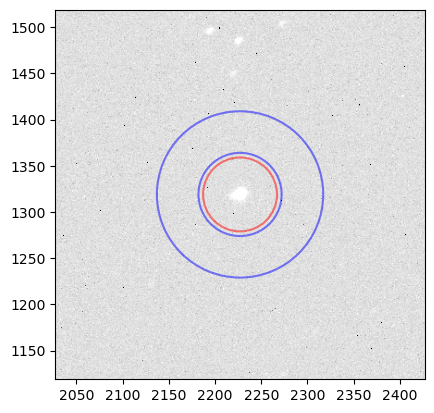

Set MJD-AVG to 60946.829436 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/19-53-22_SII_BD28_120.00s_0002_reduced.fits  with filter  SII  is  -14.773414047357326


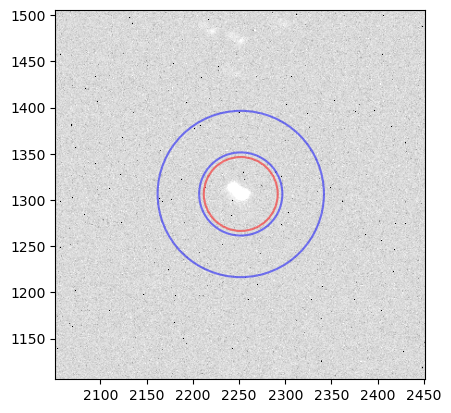

Set MJD-AVG to 60946.828036 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/19-51-21_SII_BD28_120.00s_0001_reduced.fits  with filter  SII  is  -14.772104052930375


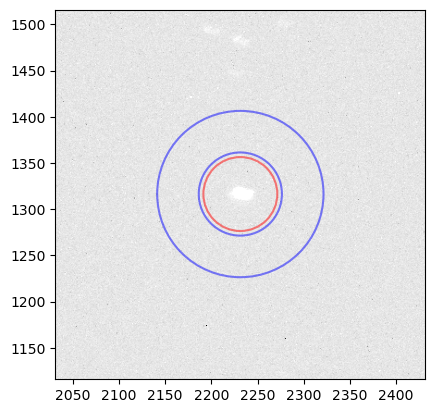

Set MJD-AVG to 60946.812582 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/19-29-46_I_BD28_40.00s_0001_reduced.fits  with filter  I  is  -16.05810170825137


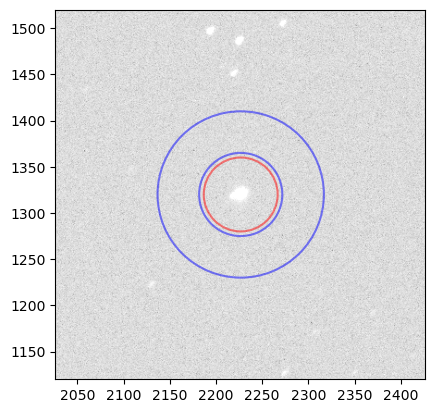

Set MJD-AVG to 60946.814007 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/19-31-10_Ha_BD28_120.00s_0000_reduced.fits  with filter  Ha  is  -14.73428666107688


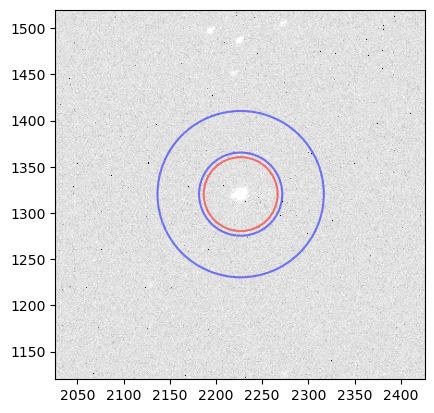

Set MJD-AVG to 60946.810796 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/19-27-19_G_BD28_25.00s_0002_reduced.fits  with filter  G  is  -16.262587513094157


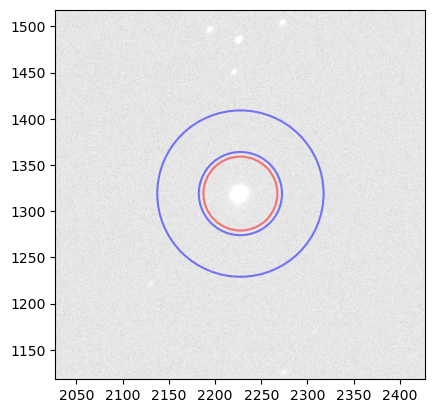

Set MJD-AVG to 60946.823829 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/19-45-18_OIII_BD28_120.00s_0001_reduced.fits  with filter  OIII  is  -14.78207762190303


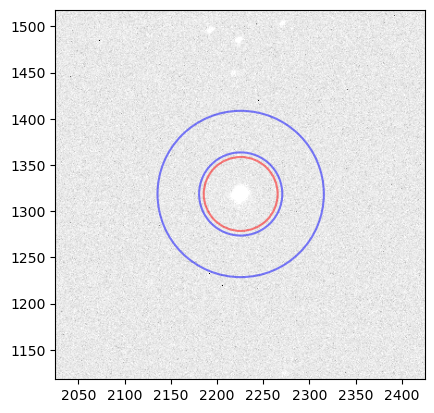

Set MJD-AVG to 60946.822428 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/19-43-17_OIII_BD28_120.00s_0000_reduced.fits  with filter  OIII  is  -14.775431837244176


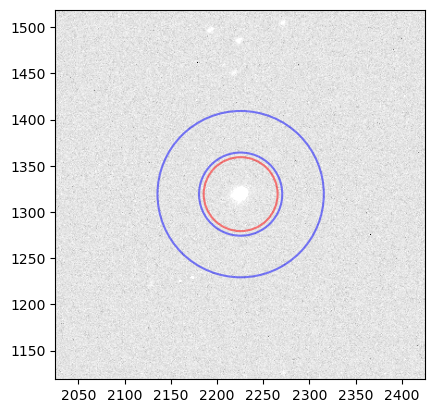

Set MJD-AVG to 60946.821010 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/19-41-14_Hb_BD28_120.00s_0002_reduced.fits  with filter  Hb  is  -14.842443109314113


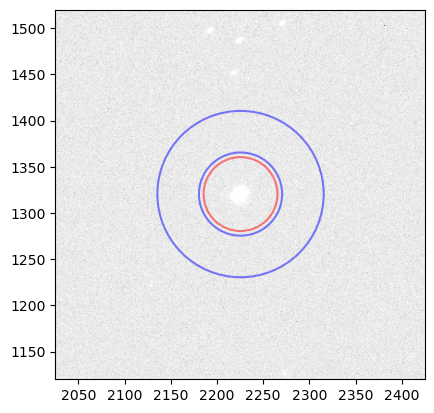

Set MJD-AVG to 60946.810205 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/19-26-28_G_BD28_25.00s_0000_reduced.fits  with filter  G  is  -16.26019093536026


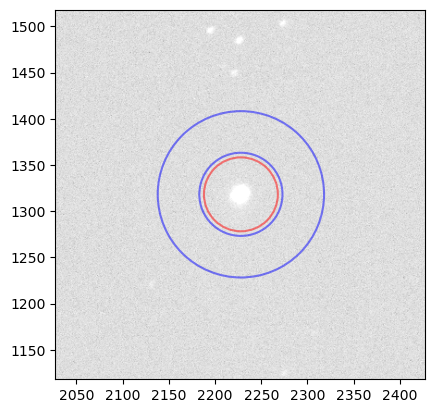

Set MJD-AVG to 60946.813055 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/19-30-27_I_BD28_40.00s_0002_reduced.fits  with filter  I  is  -16.05658192332283


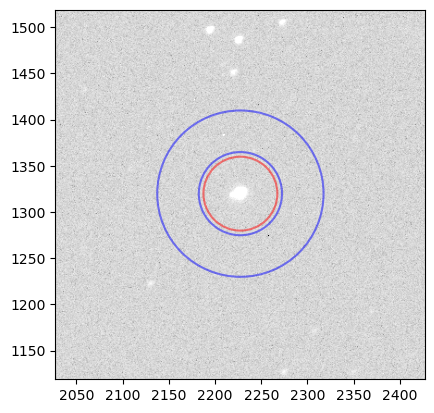

Set MJD-AVG to 60946.811712 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/19-28-39_R_BD28_25.00s_0002_reduced.fits  with filter  R  is  -16.25903945164105


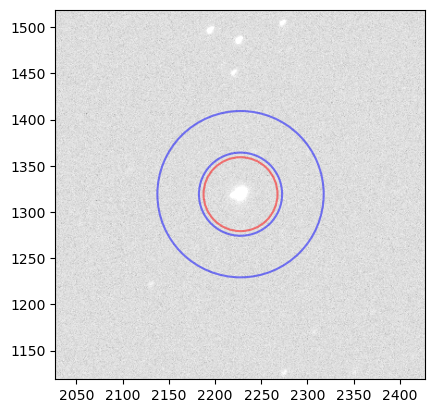

Set MJD-AVG to 60946.815402 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/19-33-10_Ha_BD28_120.00s_0001_reduced.fits  with filter  Ha  is  -14.742984300591374


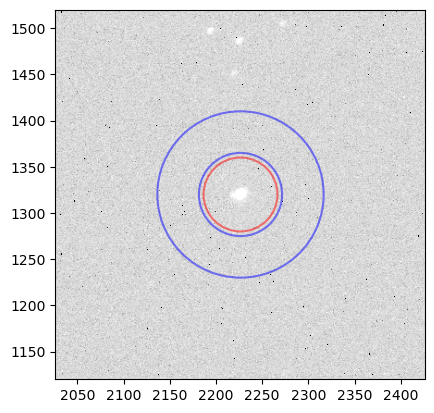

Set MJD-AVG to 60946.811115 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/19-27-47_R_BD28_25.00s_0000_reduced.fits  with filter  R  is  -16.26508017509888


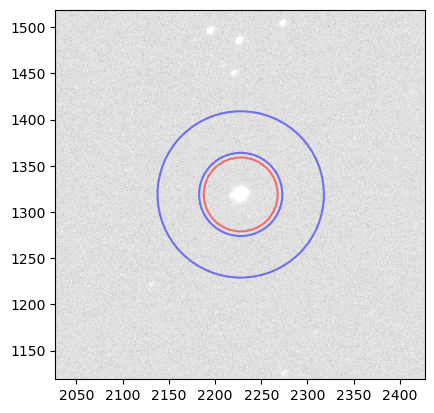

Set MJD-AVG to 60946.790349 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/18-57-55_R_BD28_20.00s_0000_reduced.fits  with filter  R  is  -16.262116460538767


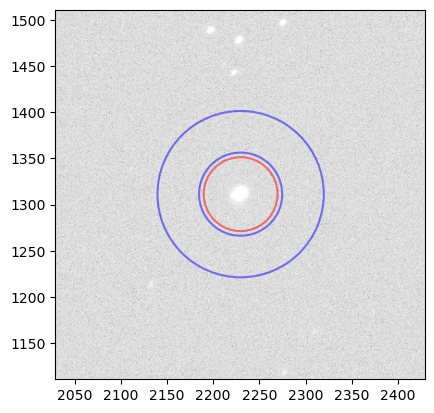

Set MJD-AVG to 60946.819615 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/19-39-14_Hb_BD28_120.00s_0001_reduced.fits  with filter  Hb  is  -14.843686107555927


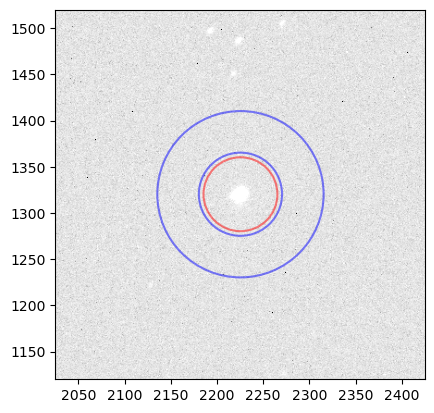

Set MJD-AVG to 60946.818221 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/19-37-13_Hb_BD28_120.00s_0000_reduced.fits  with filter  Hb  is  -14.846340990684823


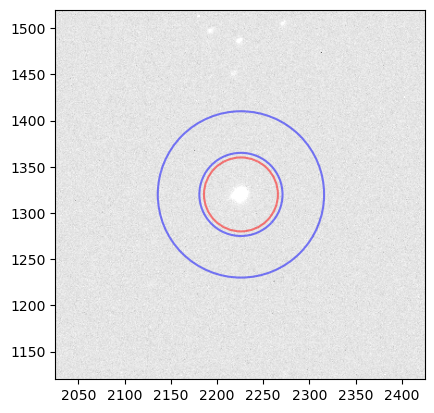

In [115]:
#start with BD28
ra=327.7958337
dec=28.8641667
for imgname in bd28names:
    runzp(imgname,coefflux28)


Set MJD-AVG to 60946.837194 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/20-04-33_Ha_BD25_120.00s_0001_reduced.fits  with filter  Ha  is  -14.732140644426396


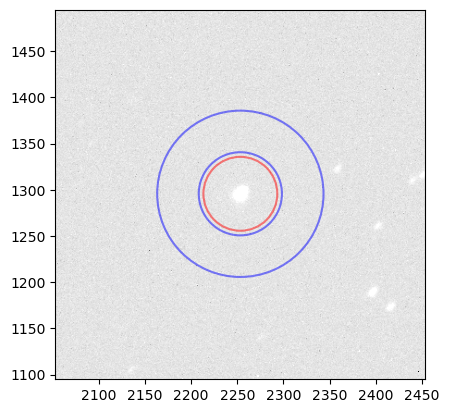

Set MJD-AVG to 60946.832291 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/19-58-17_G_BD25_25.00s_0001_reduced.fits  with filter  G  is  -16.260063325355294


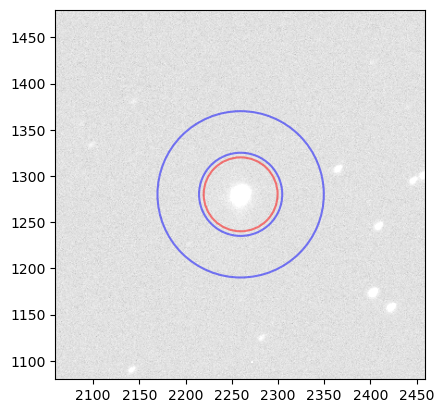

Set MJD-AVG to 60946.833900 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/20-00-28_I_BD25_40.00s_0000_reduced.fits  with filter  I  is  -16.054191468476212


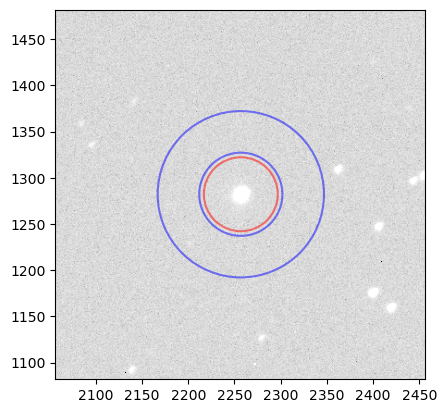

Set MJD-AVG to 60946.844216 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/20-14-39_OIII_BD25_120.00s_0000_reduced.fits  with filter  OIII  is  -14.767902196151315


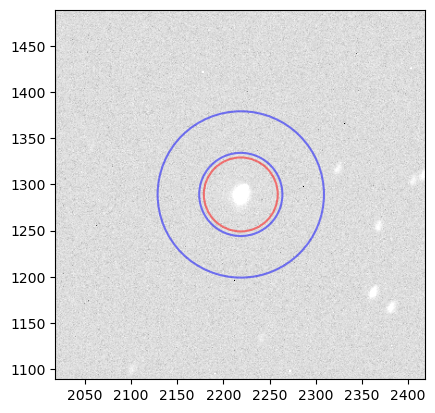

Set MJD-AVG to 60946.838588 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/20-06-33_Ha_BD25_120.00s_0002_reduced.fits  with filter  Ha  is  -14.73329538058383


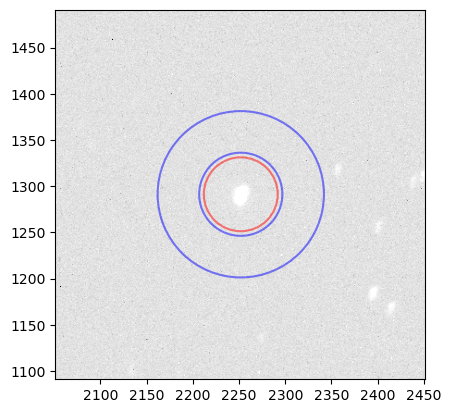

Set MJD-AVG to 60946.840006 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/20-08-36_Hb_BD25_120.00s_0000_reduced.fits  with filter  Hb  is  -14.856070388332501


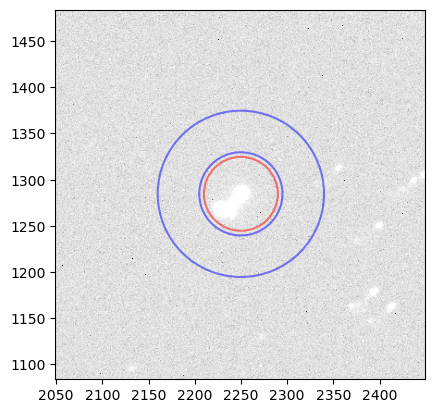

Set MJD-AVG to 60946.831989 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/19-57-50_G_BD25_25.00s_0000_reduced.fits  with filter  G  is  -16.262075036479


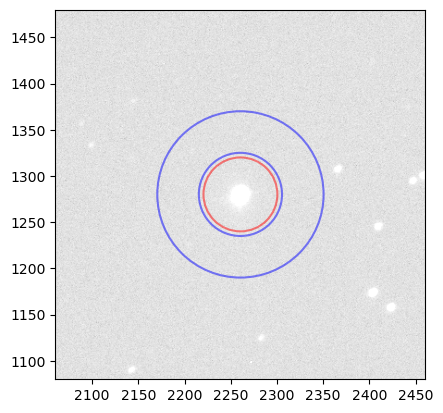

Set MJD-AVG to 60946.835798 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/20-02-32_Ha_BD25_120.00s_0000_reduced.fits  with filter  Ha  is  -14.730352691945177


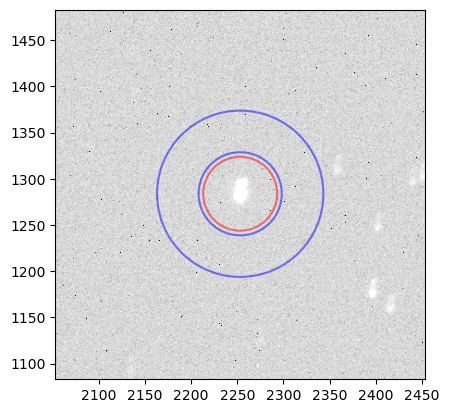

Set MJD-AVG to 60946.849824 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/20-22-44_SII_BD25_120.00s_0001_reduced.fits  with filter  SII  is  -14.762975224447079


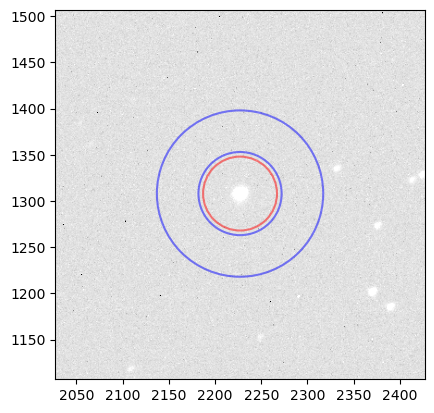

Set MJD-AVG to 60946.832587 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/19-58-42_G_BD25_25.00s_0002_reduced.fits  with filter  G  is  -16.260958420690354


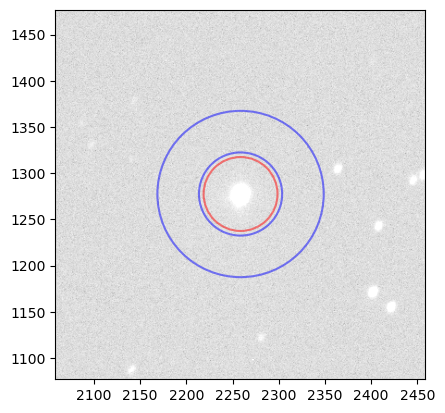

Set MJD-AVG to 60946.833494 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/20-00-01_R_BD25_25.00s_0002_reduced.fits  with filter  R  is  -16.261341474600254


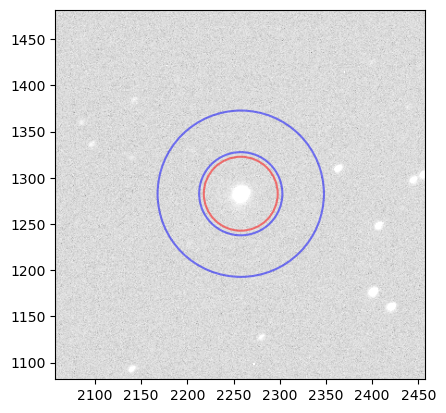

Set MJD-AVG to 60946.847017 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/20-18-41_OIII_BD25_120.00s_0002_reduced.fits  with filter  OIII  is  -14.765793430590907


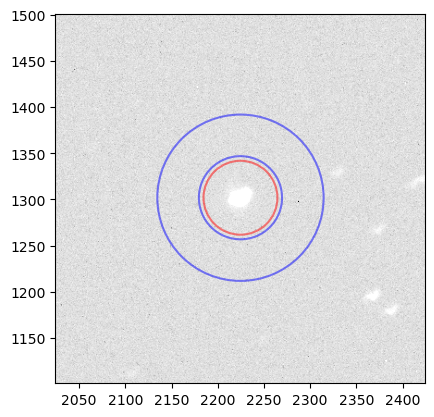

Set MJD-AVG to 60946.833198 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/19-59-35_R_BD25_25.00s_0001_reduced.fits  with filter  R  is  -16.261687294377403


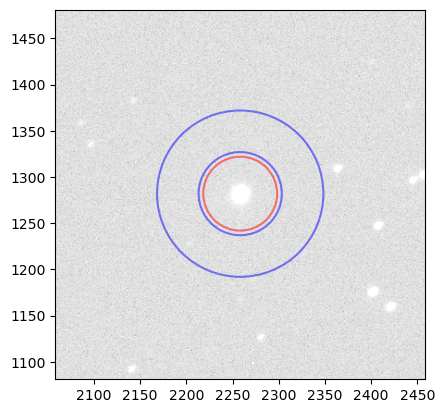

Set MJD-AVG to 60946.848429 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/20-20-44_SII_BD25_120.00s_0000_reduced.fits  with filter  SII  is  -14.766296867040577


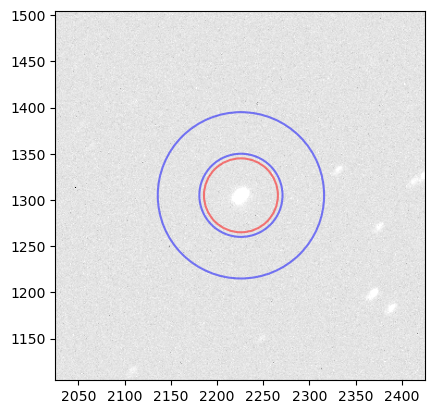

Set MJD-AVG to 60946.834376 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/20-01-09_I_BD25_40.00s_0001_reduced.fits  with filter  I  is  -16.056410603745757


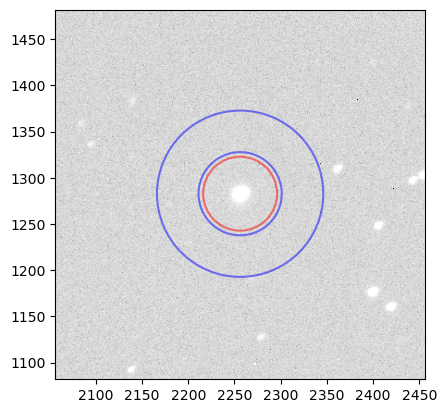

Set MJD-AVG to 60946.845617 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/20-16-40_OIII_BD25_120.00s_0001_reduced.fits  with filter  OIII  is  -14.768249877874467


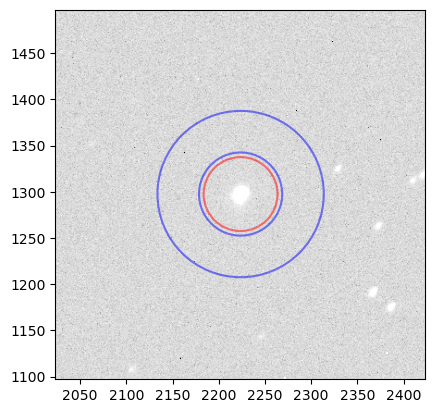

Set MJD-AVG to 60946.851224 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/20-24-45_SII_BD25_120.00s_0002_reduced.fits  with filter  SII  is  -14.769473470211517


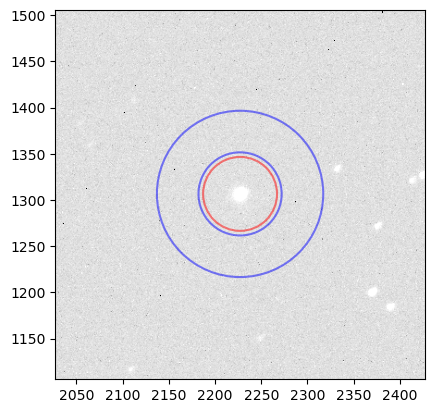

Set MJD-AVG to 60946.841407 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/20-10-37_Hb_BD25_120.00s_0001_reduced.fits  with filter  Hb  is  -14.857373970006385


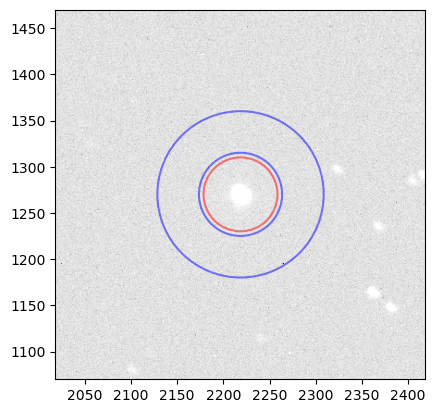

Set MJD-AVG to 60946.842802 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/20-12-38_Hb_BD25_120.00s_0002_reduced.fits  with filter  Hb  is  -14.853023378553546


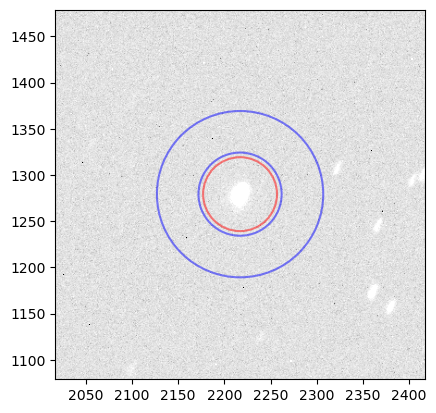

Set MJD-AVG to 60946.832902 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/19-59-09_R_BD25_25.00s_0000_reduced.fits  with filter  R  is  -16.259378893254052


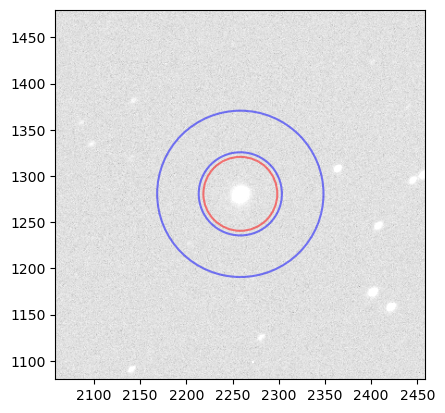

Set MJD-AVG to 60946.834846 from DATE-AVG'. [astropy.wcs.wcs]


ZP for  ./data/Redux/20-01-50_I_BD25_40.00s_0002_reduced.fits  with filter  I  is  -16.051858375622032


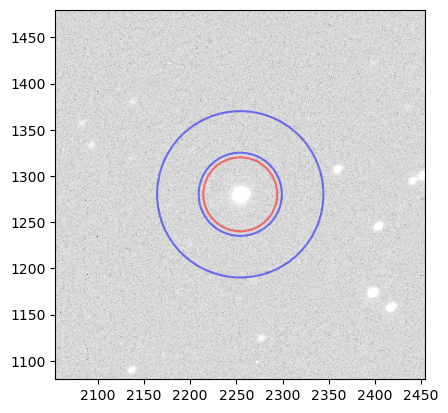

In [116]:
#now with BD25
ra=329.9250000
dec=26.4327778
for imgname in bd25names:
    runzp(imgname,coefflux25)


In [117]:
print(zpall)

{'R': [-16.263267718840464, -16.25903945164105, -16.26508017509888, -16.262116460538767, -16.261341474600254, -16.261687294377403, -16.259378893254052], 'G': [-16.261814819688773, -16.262587513094157, -16.26019093536026, -16.260063325355294, -16.262075036479, -16.260958420690354], 'I': [-16.057043784375697, -16.05810170825137, -16.05658192332283, -16.054191468476212, -16.056410603745757, -16.051858375622032], 'SII': [-14.759037771858194, -14.773414047357326, -14.772104052930375, -14.762975224447079, -14.766296867040577, -14.769473470211517], 'OIII': [-14.77175141568965, -14.78207762190303, -14.775431837244176, -14.767902196151315, -14.765793430590907, -14.768249877874467], 'Ha': [-14.736885596109161, -14.73428666107688, -14.742984300591374, -14.732140644426396, -14.73329538058383, -14.730352691945177], 'Hb': [-14.842443109314113, -14.843686107555927, -14.846340990684823, -14.856070388332501, -14.857373970006385, -14.853023378553546]}


In [118]:
zpfinal={}

for filt in listfilter.keys():
    print('ZP for filter ', filt, ' is ', np.median(zpall[filt]), ' with std ', np.std(zpall[filt]), ' from ', len(zpall[filt]), ' measurements')
    zpfinal[filt]=np.median(zpall[filt])

ZP for filter  R  is  -16.261687294377403  with std  0.001951245120600648  from  7  measurements
ZP for filter  G  is  -16.261386620189562  with std  0.0009484602426074734  from  6  measurements
ZP for filter  I  is  -16.056496263534292  with std  0.0020772749005869063  from  6  measurements
ZP for filter  SII  is  -14.767885168626048  with std  0.00505168977596202  from  6  measurements
ZP for filter  OIII  is  -14.770000646782059  with std  0.005517694388010845  from  6  measurements
ZP for filter  Ha  is  -14.733791020830354  with std  0.004092513402620491  from  6  measurements
ZP for filter  Hb  is  -14.849682184619184  with std  0.005923653942410849  from  6  measurements


In [121]:
#now calibrate the sky
for filt in listfilter.keys():
    if(len(skyall[filt])>0):
        print('Sky for filter ', filt, ' is ', np.median(skyall[filt])*10**(zpfinal[filt]), ' with std ', np.std(skyall[filt])*10**(zpfinal[filt]), ' from ', len(skyall[filt]), ' measurements')

Sky for filter  R  is  1.1041243967286826e-14  with std  2.397865176882614e-16  from  7  measurements
Sky for filter  G  is  1.579793200549483e-14  with std  1.4474895534709592e-16  from  6  measurements
Sky for filter  I  is  5.514757450277637e-15  with std  4.659352589952402e-17  from  6  measurements
Sky for filter  SII  is  2.8515950523910174e-15  with std  3.204085727720343e-17  from  6  measurements
Sky for filter  OIII  is  1.0637337469350953e-14  with std  2.0122457235990413e-16  from  6  measurements
Sky for filter  Ha  is  4.098847959575532e-15  with std  8.494272389493503e-17  from  6  measurements
Sky for filter  Hb  is  7.868530123243208e-15  with std  1.4746675973221347e-16  from  6  measurements
